WHAT IF 2: più o meno bici in circolazione

# Libraries

In [ ]:
import pandas as pd
import numpy as np
import random
import json
import pickle
import ast
from geopy import distance
import sys, os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(20,8)})
from collections import Counter
import calendar
from datetime import datetime, timedelta

# statistical
from sklearn.neighbors import KernelDensity

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

base_path = '/content/gdrive/MyDrive/complexsystems/'

Mounted at /content/gdrive


# Functions

In [ ]:
def transform_data(df):
  df = df.copy().dropna()
  
  df['started_at_round'] = pd.to_datetime(df['time1'], errors='coerce')
  df['ended_at_round'] = pd.to_datetime(df['time2'], errors='coerce')
  df['start'] = df['started_at_round'].dt.strftime('%H:%M')
  df['end'] = df['ended_at_round'].dt.strftime('%H:%M')
  
  df['day'] = df['started_at_round'].dt.date
  df['month'] = df['started_at_round'].dt.month
  df['week'] = df['started_at_round'].dt.isocalendar().week
  df['weekday'] = df['started_at_round'].dt.dayofweek

  df['season'] = df['started_at_round'].dt.month % 12 // 3 + 1 # le raggruppa a inizio mese, non nella data precisa
  df['weekend'] = df['started_at_round'].dt.dayofweek > 4
  df['hour_group'] = regroup_values(list(df['started_at_round'].dt.hour), 3)
  return df

# into intervals of size n
def regroup_values(values, n):
  return [n*(h//n) for h in values]

# Analysis

### Read files

In [ ]:
df = pd.read_csv(base_path+'data/preprocessed/preprocessed_data_san_jose.csv', converters={"coords1": ast.literal_eval,"coords2": ast.literal_eval})
df = transform_data(df)
STATIONS = set(df['id1']).union(set(df['id2']))

In [ ]:
start_date = datetime(2018, 1, 1, 0, 0, 0)
end_date = datetime(2019, 1, 1, 0, 0, 0)

In [ ]:
# real data
real = df.copy()
real['time1'] = pd.to_datetime(real['time1'])
real['time2'] = pd.to_datetime(real['time2'])
real = real[(real['time1']>=start_date) & (real['time1']<end_date)].sort_values(by='time1')

In [ ]:
# simulation data
h1 = pd.read_csv(base_path+'data/simulation_history_whatif_2/history_seed261_start2018-01-01_end2019-01-01_stationNone_bikes400.csv')
h2 = pd.read_csv(base_path+'data/simulation_history_whatif_2/history_seed126_start2018-01-01_end2019-01-01_stationNone_bikes900.csv')
h3 = pd.read_csv(base_path+'data/simulation_history_whatif_2/history_seed891_start2018-01-01_end2019-01-01_stationNone_bikes1400.csv')

### Trips

In [ ]:
tmp = real[(real['duration']>=1) & (real['duration']<=100)].copy()
dr = tmp['duration'].describe()
d1 = h1['duration'].describe()
d2 = h2['duration'].describe()
d3 = h3['duration'].describe()

tmp = pd.DataFrame(pd.concat([dr, d1, d2, d3], axis=1))
tmp.columns = ['real', 'h1', 'h2', 'h3']
tmp

,real,h1,h2,h3
count,86841.000000,35898.000000,47718.000000,56548.000000
mean,10.701367,10.591259,10.576302,10.582337
std,9.900250,4.088934,4.080861,4.082426
min,1.016667,5.000000,5.000000,5.000000
25%,5.550000,10.000000,10.000000,10.000000
50%,8.383333,10.000000,10.000000,10.000000
75%,11.933333,15.000000,15.000000,15.000000
max,99.933333,35.000000,35.000000,40.000000


Real data


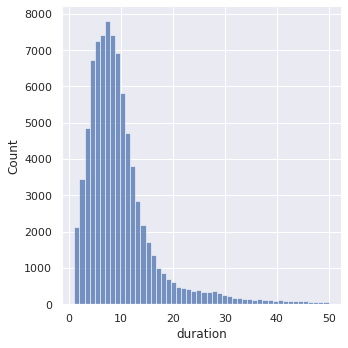

Simulation 1


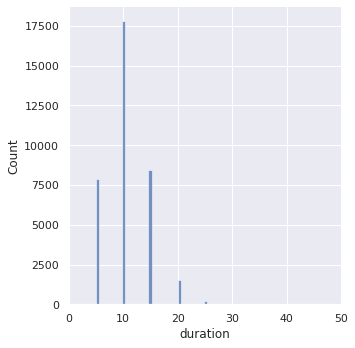

Simulation 2


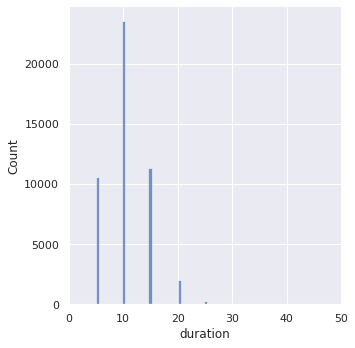

Simulation 3


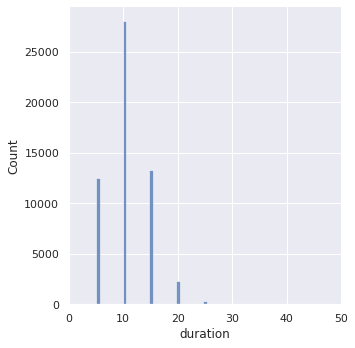

In [ ]:
xmax = 50

print('Real data')
tmp = real.copy()
tmp = tmp[tmp['duration']<=xmax]
sns.displot(tmp['duration'], bins=50)
plt.show();

print('Simulation 1')
sns.displot(h1['duration'], bins=50)
plt.xlim([0,xmax])
plt.show();

print('Simulation 2')
sns.displot(h2['duration'], bins=50)
plt.xlim([0,xmax])
plt.show();

print('Simulation 3')
sns.displot(h3['duration'], bins=50)
plt.xlim([0,xmax])
plt.show();

### Stations

Real data


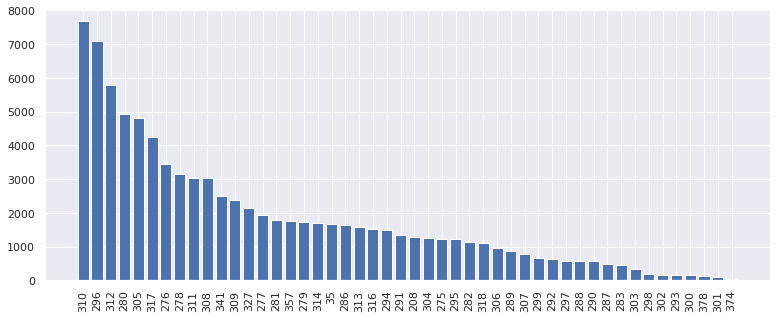

Simulation 1


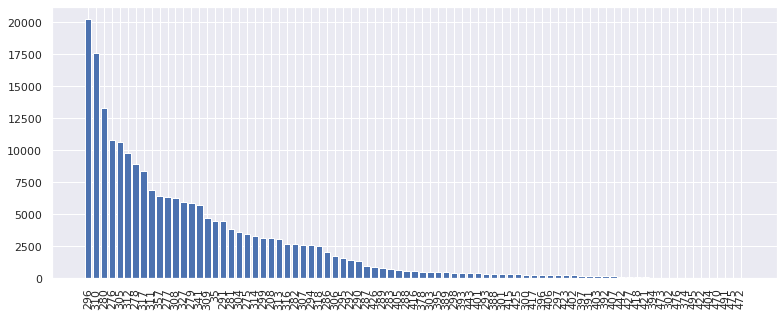

Simulation 2


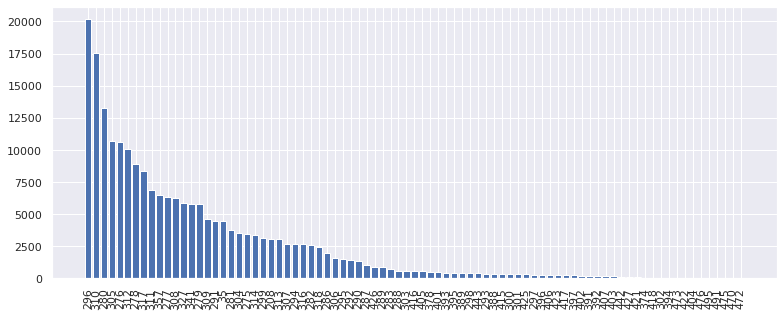

Simulation 3


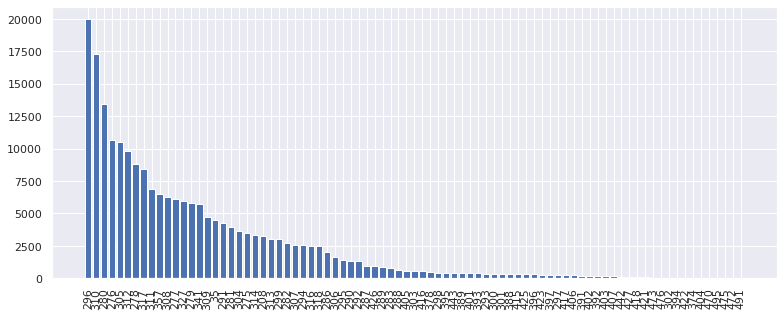

In [ ]:
plt.rcParams["figure.figsize"] = (13,5)

print('Real data')
x = pd.value_counts(real['id1'])
labels = [str(l) for l in x.index]
count = list(x)
plt.bar(labels, count)
plt.xticks(rotation=90)
plt.show();

print('Simulation 1')
x = pd.value_counts(h1['id1'])
labels = [str(l) for l in x.index]
count = list(x)
plt.bar(labels, count)
plt.xticks(rotation=90)
plt.show();

print('Simulation 2')
x = pd.value_counts(h2['id1'])
labels = [str(l) for l in x.index]
count = list(x)
plt.bar(labels, count)
plt.xticks(rotation=90)
plt.show();

print('Simulation 3')
x = pd.value_counts(h3['id1'])
labels = [str(l) for l in x.index]
count = list(x)
plt.bar(labels, count)
plt.xticks(rotation=90)
plt.show();

### Bikes

Real data
904 bikes


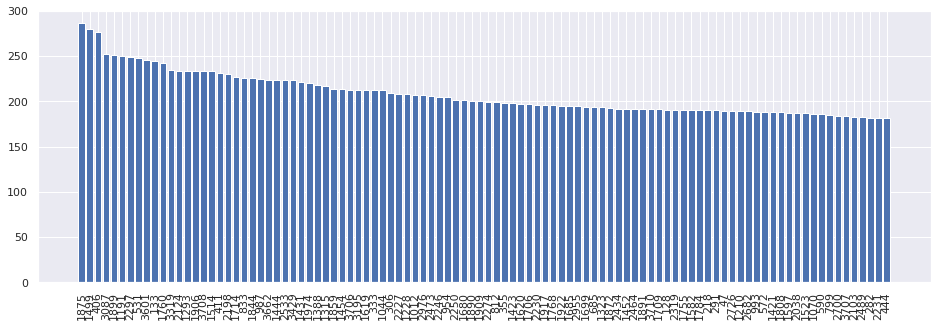

Simulation 1
394 bikes


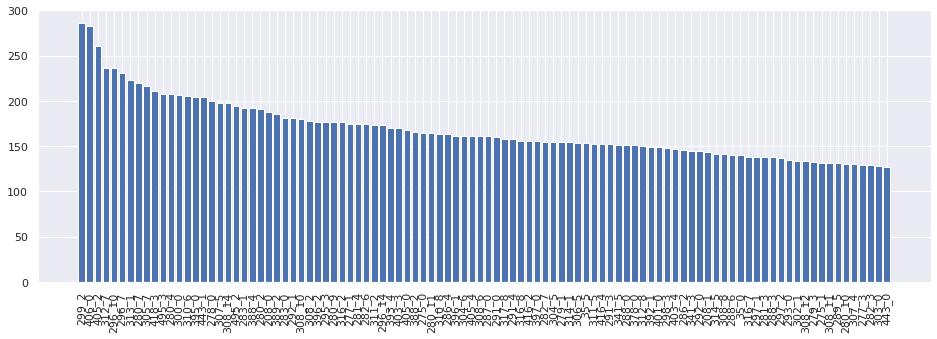

Simulation 2
887 bikes


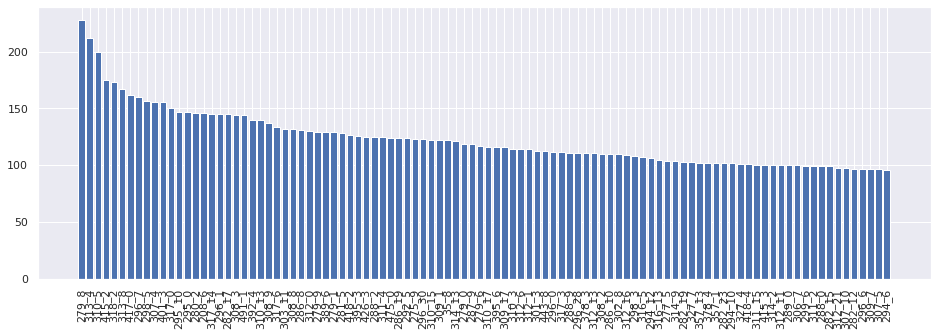

Simulation 3
1370 bikes


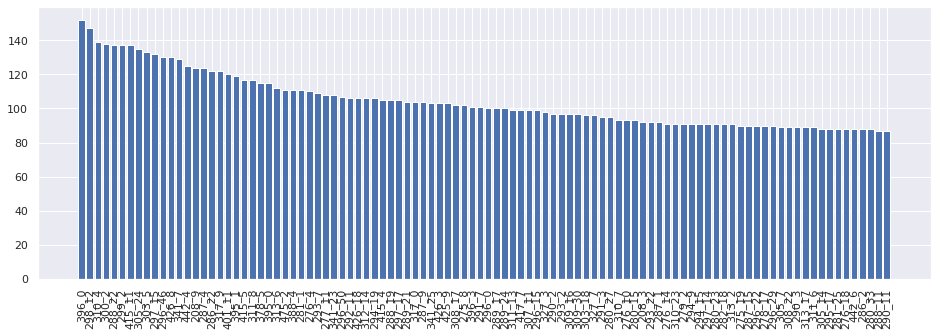

In [ ]:
plt.rcParams["figure.figsize"] = (16,5)

print('Real data')
x = pd.value_counts(real['bike_id'])
print(len(x), 'bikes')
x = x.head(100)
labels = [str(l) for l in x.index]
count = list(x)
plt.bar(labels, count)
plt.xticks(rotation=90)
plt.show();

print('Simulation 1')
x = pd.value_counts(h1['bike_id'])
print(len(x), 'bikes')
x = x.head(100)
labels = [str(l) for l in x.index]
count = list(x)
plt.bar(labels, count)
plt.xticks(rotation=90)
plt.show();

print('Simulation 2')
x = pd.value_counts(h2['bike_id'])
print(len(x), 'bikes')
x = x.head(100)
labels = [str(l) for l in x.index]
count = list(x)
plt.bar(labels, count)
plt.xticks(rotation=90)
plt.show();

print('Simulation 3')
x = pd.value_counts(h3['bike_id'])
print(len(x), 'bikes')
x = x.head(100)
labels = [str(l) for l in x.index]
count = list(x)
plt.bar(labels, count)
plt.xticks(rotation=90)
plt.show();

### Lost trips

In [ ]:
tmp = h1[h1['lost']]
tmp = pd.value_counts(tmp['id1'])
print('Total lost trips in h1:', np.sum(tmp))

tmp = h2[h2['lost']]
tmp = pd.value_counts(tmp['id1'])
print('Total lost trips in h2:', np.sum(tmp))

tmp = h3[h3['lost']]
tmp = pd.value_counts(tmp['id1'])
print('Total lost trips in h3:', np.sum(tmp))

# stazioni con più viaggi persi sono nello stesso ordine delle stazioni più usate

Total lost trips in h1: 179833
Total lost trips in h2: 167064
Total lost trips in h3: 157364
